In [1]:
import time 
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from numpy.core import shape_base
from numpy.core.fromnumeric import shape
from integration_methods import Leapfrog_step
from test_constants import CoM_pos, CoM_vel, angular_momentum, total_energy, kinetic_energy
from ode_function import ode_func

Plots the fill_matrix for a given successful perturbation simulation.

In [16]:
################################ Setup ################################ 
######## CHANGE VALUES BELOW ########
# Setup values
# Approx 16 orbits per 100 time units
duration = 150 # time units, not seconds
dt = 0.001 # Not needed if CFL stepping, but needs to be declared

## Courant number
C = 0.1

# Energy error threshold
e_thresh = 0.05
box_size = 10
timestep_size = 10e-4
timestep_count = 100000

# Gravitational constant
G = 1
#G = 6.67408e-11

######## CHANGE VALUES ABOVE ########

In [17]:
def perturb_fig_8(v_x_perturbation = 0,v_y_perturbation = 0,plot_more = False,E_start=0):
    '''
    Runs the simulation with a perturbation to initial conditions
    Defaults to no perturbation
    '''
    # Fig 8
    mass = (1,1,1) # Equal masses
    n_bodies = round(len(mass))
    x_IC_x = 0.97000436
    x_IC_y = 0.24308753
    v_IC_x = -0.93240737
    v_IC_y = -0.86473146
    x_ICs = (x_IC_x,-x_IC_y,0,-x_IC_x,x_IC_y,0,0,0,0) # x,y,z,x,y,z,...
    v_ICs = (-v_IC_x/2,-v_IC_y/2,0,-v_IC_x/2,-v_IC_y/2,0,v_IC_x,v_IC_y,0) # x,y,z,x,y,z,...

    ###### Perturb the v_ICs
    v_perturb_x = v_IC_x+v_x_perturbation
    v_perturb_y = v_IC_y+v_y_perturbation
    v_ICs = (-v_perturb_x/2,-v_perturb_y/2,0,-v_perturb_x/2,-v_perturb_y/2,0,v_perturb_x,v_perturb_y,0) # x,y,z,x,y,z,...
    v_ICs = np.asarray(v_ICs)
    v_array = np.empty((3*n_bodies,1))
    v_array[:,0] = np.transpose(v_ICs)

    ###### Perturb the x_ICs
    m = 1
    R_hat = 5*G*m/(2*(np.sum(kinetic_energy(v_array[:,0],mass)) - E_start))
    theta = np.arctan(np.abs(x_IC_y)/np.abs(x_IC_x))
    x_perturb_x = np.abs(R_hat*np.cos(theta))
    x_perturb_y = np.abs(R_hat*np.sin(theta))
    x_ICs = (x_perturb_x,-x_perturb_y,0,-x_perturb_x,x_perturb_y,0,0,0,0) # x,y,z,x,y,z,..   
    x_ICs = np.asarray(x_ICs)


    # Check number of bodies is consistent
    if len(x_ICs) != len(v_ICs) or len(x_ICs) != len(mass)*3:
        raise Exception('Position and velocity IC vectors must both have 3 times the length of the masses vector')

    x_array = np.empty((3*n_bodies,1))
    x_array[:,0] = np.transpose(x_ICs)

    ##  Tracking 'conserved' quantities, and reset to CoM frame
    # CoM position
    CoM = np.empty((3,1))
    CoM[:,0] = CoM_pos(x_array[:,0],mass) # Initial CoM
    # CoM velocity
    CoM_v = np.empty((3,1))
    CoM_v[:,0] = CoM_vel(v_array[:,0],mass) # Initial CoM

    # In centre of mass frame
    CoM_pos_array = np.tile(CoM,(n_bodies,1))
    x_array[:,0] = x_array[:,0] - CoM_pos_array[:,0]
    CoM_vel_array = np.tile(CoM_v,(n_bodies,1))
    v_array[:,0] = v_array[:,0] - CoM_vel_array[:,0]

    # Energy
    E_start,r = total_energy(x_array[:,0],v_array[:,0],mass,G) # Initial energy

    ## These are similar to above, except for just CFL values
    ## dt_CFL_prog is for plotting over time
    dt_CFL_prog = np.empty(1)
    dt_CFL_prog[0] = 0
    ## dt_CFL_store is storing each dt
    dt_CFL_store= []

    ################################ Run method ################################
    
    i = -1
    while dt_CFL_prog[-1] < duration:
        i += 1
        #### Step forward
        ## Finding CFL dt values
        del_t = np.ones((n_bodies,n_bodies))
        for j in range(n_bodies):
            for k in range(j+1,n_bodies):
                if r[j,k] != 0:
                    del_t[j,k] = (C * r[j,k])/np.linalg.norm(v_array[3*j:(j+1)*3,i] - v_array[3*k:(k+1)*3,i])
                else:
                    del_t[j,k] = np.max(del_t)
                del_t[k,j] = del_t[j,k]
        dt_CFL_0 = np.min(del_t)
        dt = dt_CFL_0 # Actual timestep to be used
        # Update position and velocity 
        x_array_test,v_array_test,_ = Leapfrog_step(x_array[:,i],v_array[:,i],ode_func,dt,mass,G,force_eval = [])
    
        r_1 = np.zeros((n_bodies,n_bodies))
        x = x_array_test.reshape((3,-1),order = 'F')
        for ii in range(n_bodies):
            for jj in range(ii+1,n_bodies):
                # Loop over each pair once and then dupilicate, so save computing each time
                r_1[ii,jj] = np.linalg.norm(x[:,ii] - x[:,jj])
                r_1[jj,ii] = r_1[ii,jj]
        #### Recalculate dt at future timestep
        ## Finding CFL dt values
        del_t = np.ones((n_bodies,n_bodies))
        for j in range(n_bodies):
            for k in range(j+1,n_bodies):
                if r_1[j,k] != 0:
                    del_t[j,k] = (C * r_1[j,k])/np.linalg.norm(v_array_test[3*j:(j+1)*3] - v_array_test[3*k:(k+1)*3])
                else:
                    del_t[j,k] = np.max(del_t)
                del_t[k,j] = del_t[j,k]

        dt_CFL_1 = np.min(del_t) # Current variable timestep
        # Calculate timestep to use
        dt_CFL = (1/2) * (dt_CFL_0 + dt_CFL_1)
        # Store and use this dt_CFL
        dt_CFL_prog = np.append(dt_CFL_prog,dt_CFL_prog[i] + dt_CFL) # This is cumulative vector of dt
        dt_CFL_store = np.append(dt_CFL_store,dt_CFL) # This stores dt at each time
        dt = dt_CFL
        # Update position and velocity
        if i > 0:
            x_array_hold,v_array_hold,force_eval = Leapfrog_step(x_array[:,i],v_array[:,i],ode_func,dt,mass,G,force_eval)
        else: 
            x_array_hold,v_array_hold,force_eval = Leapfrog_step(x_array[:,i],v_array[:,i],ode_func,dt,mass,G,force_eval=[])
        x_array = np.append(x_array,np.reshape(np.asarray(x_array_hold),(-1,1)),axis=1)
        v_array = np.append(v_array,np.reshape(np.asarray(v_array_hold),(-1,1)),axis=1)

        x = x_array[:,i+1].reshape((3,-1),order = 'F')
        r = np.zeros((n_bodies,n_bodies))
        for iii in range(n_bodies):
            for jjj in range(iii+1,n_bodies):
                # Loop over each pair once and then dupilicate, so save computing each time
                r[iii,jjj] = np.linalg.norm(x[:,iii] - x[:,jjj])
                r[jjj,iii] = r[iii,jjj]
                
        ## Stop if position or energy error grows too large
        final_it = i+1 # Final iteration
        if np.mod(i,100) == 0:
            E_hold,_ = total_energy(x_array[:,i+1],v_array[:,i+1],mass,G)
            # Every 100 steps, check
            if any(np.abs(x_array[:,i+1]) > box_size):
                # If position goes outside square/cube of side length 2*box_size, centred on origin
                print('Outside box of size {}, so terminated at time {}'.format(box_size,dt_CFL_prog[i+1]))
                failure_class = 1
                return failure_class, x_array

            elif np.abs((E_hold - E_start)/E_start) > e_thresh:
                # If energy error goes above the threshold
                print('Rel energy error is above {}, so terminated at time {}'.format(e_thresh,dt_CFL_prog[i+1]))
                failure_class = 2
                return failure_class, x_array

            elif dt < timestep_size:
                # If timestep size goes below the threshold
                print('Timestep size is below {}, so terminated at time {}'.format(timestep_size,dt_CFL_prog[i+1]))
                failure_class = 3
                return failure_class, x_array

            elif i > timestep_count:
                # If too many timesteps
                print('More than {} timesteps, so terminated at time {}'.format(timestep_count,dt_CFL_prog[i+1]))
                failure_class = 4
                return failure_class, x_array

    failure_class = 0  #If it reaches the end, it stays as a fig-8
    print('Ran for full duration (finish time: {})'.format(dt_CFL_prog[final_it]))
    return failure_class, x_array

In [32]:
#### Original energy
mass = (1,1,1) # Equal masses
n_bodies = round(len(mass))
x_IC_x = 0.97000436
x_IC_y = 0.24308753
v_IC_x = -0.93240737
v_IC_y = -0.86473146
x_ICs = (x_IC_x,-x_IC_y,0,-x_IC_x,x_IC_y,0,0,0,0) # x,y,z,x,y,z,...
v_ICs = (-v_IC_x/2,-v_IC_y/2,0,-v_IC_x/2,-v_IC_y/2,0,v_IC_x,v_IC_y,0) # x,y,z,x,y,z,...
x_ICs = np.asarray(x_ICs)
v_ICs = np.asarray(v_ICs)
x_array_1 = np.empty((3*n_bodies,1))
x_array_1[:,0] = np.transpose(x_ICs)
v_array_1 = np.empty((3*n_bodies,1))
v_array_1[:,0] = np.transpose(v_ICs)
E_start,_ = total_energy(x_array_1[:,0],v_array_1[:,0],mass,G)
#####

# Single perturbation, for testing
v_x_perturbation = -0.2296875 #-0.228125 
v_y_perturbation = -0.0765625 #-0.07734375 
plot_more = False
_,x_array = perturb_fig_8(v_x_perturbation,v_y_perturbation,plot_more,E_start=E_start)

<ipython-input-17-327ecb0b5ada>:85: RuntimeWarning: divide by zero encountered in double_scalars
  del_t[j,k] = (C * r[j,k])/np.linalg.norm(v_array[3*j:(j+1)*3,i] - v_array[3*k:(k+1)*3,i])


Ran for full duration (finish time: 150.0393351205299)


[1.68661591 1.68431472 1.6780293  ... 1.12147    1.11278189 1.1058366 ]
[0.84330795 0.79604476 0.75472802 ... 1.48800821 1.56917484 1.64792187]
[0.84330795 0.89327887 0.94200894 ... 2.18856005 2.14958602 2.10312062]


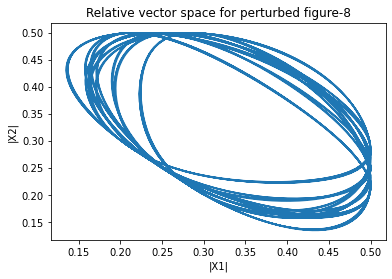

3162.0


In [33]:
r1 = x_array[:3,:]
r2 = x_array[3:6,:]
r3 = x_array[6:,:]
R1 = r1 - r2
R2 = r2 - r3
R3 = r1 - r3

print(np.linalg.norm(R1,axis = 0))
print(np.linalg.norm(R2,axis = 0))
print(np.linalg.norm(R3,axis = 0))
N = np.linalg.norm(R1,axis = 0) + np.linalg.norm(R2,axis = 0) + np.linalg.norm(R3,axis = 0)
X1 = R1/N
X2 = R2/N
X1_norm = np.linalg.norm(X1,axis = 0)
X2_norm = np.linalg.norm(X2,axis = 0)
# These sum to 1 for all time

plt.plot(X1_norm,X2_norm)
plt.xlabel('|X1|')
plt.ylabel('|X2|')
plt.title('Relative vector space for perturbed figure-8')
plt.show()

fill_matrix = np.zeros((1000,1000))
X1_round = np.rint(X1_norm*1000).astype(int)
X2_round = np.rint(X2_norm*1000).astype(int)
for i in range(len(X1_round)):
    fill_matrix[X1_round[i],X2_round[i]] = 1


print(np.sum(fill_matrix))

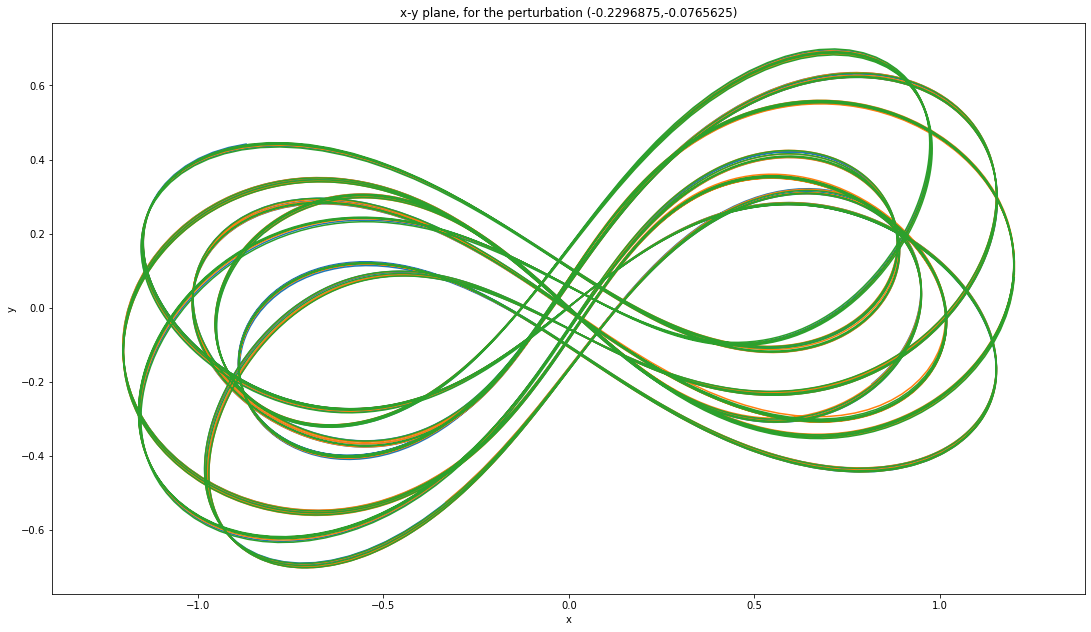

In [34]:
fig, ax0 = plt.subplots()
n_bodies = 3

fig.set_size_inches(18.5, 10.5)
ax0.set_title('x-y plane, for the perturbation ({},{})'.format(v_x_perturbation,v_y_perturbation))
ax0.axis('equal')
elements = np.arange(start = 0,stop = (n_bodies)*3,step = 3).astype(int)
ax0.plot(np.transpose(x_array[elements,:]),np.transpose(x_array[elements+1,:]))
ax0.set_xlabel('x')
ax0.set_ylabel('y')
plt.show()

[ 0.46620368  0.43236573  0.          0.46620368  0.43236573  0.
 -0.93240737 -0.86473146  0.        ]
